In [21]:
!pip install vllm torch hf_transfer flash-attn  --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
from pathlib import Path
from IPython.display import Image, display
from transformers import AutoTokenizer
from PIL import Image as PilImage
from vllm import LLM, SamplingParams
from vllm.assets.image import ImageAsset
from vllm.utils import FlexibleArgumentParser
from vllm.distributed.parallel_state import destroy_model_parallel, destroy_distributed_environment
import torch
import gc
import requests
import torch
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration, LlavaForConditionalGeneration

from io import BytesIO
from transformers import AutoProcessor, AutoModelForVision2Seq

In [60]:

# del llm
# del tokenizer
gc.collect()
torch.cuda.empty_cache()

In [8]:
question = """Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы."""

## MiniCRM-v2.6

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download openbmb/MiniCPM-V-2_6

In [9]:
model_name = "openbmb/MiniCPM-V-2_6"
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                              trust_remote_code=True)
llm = LLM(
    model=model_name,
    max_model_len=4096,
    max_num_seqs=2,
    trust_remote_code=True,
)

INFO 11-11 22:37:49 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='openbmb/MiniCPM-V-2_6', speculative_config=None, tokenizer='openbmb/MiniCPM-V-2_6', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=openbmb/MiniCPM-V-2_6, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enable_prefix_cac

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:04,  1.67s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:02<00:02,  1.16s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:03<00:00,  1.04it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.35it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.11it/s]



INFO 11-11 22:37:55 model_runner.py:1067] Loading model weights took 15.1848 GB
INFO 11-11 22:37:56 gpu_executor.py:122] # GPU blocks: 64541, # CPU blocks: 4681
INFO 11-11 22:37:56 gpu_executor.py:126] Maximum concurrency for 4096 tokens per request: 252.11x
INFO 11-11 22:37:56 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-11 22:37:56 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-11 22:37:57 model_runner.py:1523] Graph capturing finished in 1 secs.


In [4]:
stop_tokens = ['<|im_end|>', '<|endoftext|>']
stop_token_ids = [tokenizer.convert_tokens_to_ids(i) for i in stop_tokens]

messages = [{
    'role': 'user',
    'content': f'(<image>./</image>)\n{question}'
}]
prompt = tokenizer.apply_chat_template(messages,
                                       tokenize=False,
                                       add_generation_prompt=True)

In [5]:
sampling_params = SamplingParams(temperature=0,
                                     max_tokens=None,
                                     stop_token_ids=stop_token_ids)

Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it, est. speed input: 137.66 toks/s, output: 80.48 toks/s]


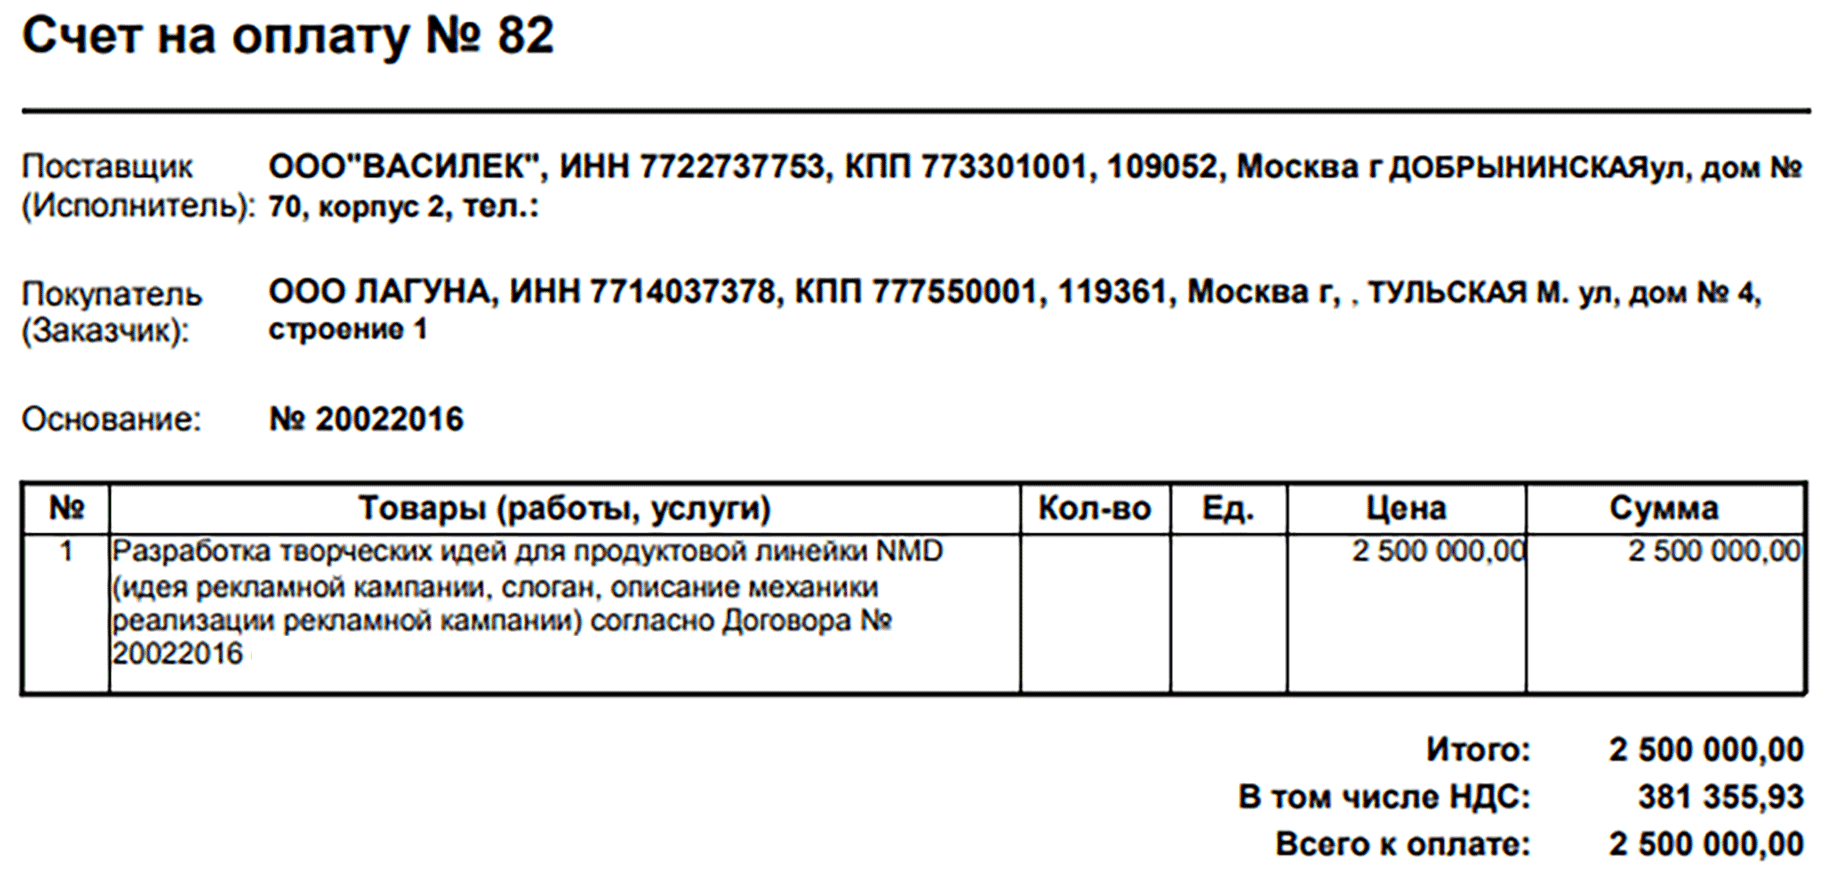

**Счет № 82**

**Поставщик (Исполнитель):** ООО "ВАСИЛЬЕК", ИНН 7722737753, КПП 773301001, 109052, Москва, ул. Добринская, дом № 70, корпус 2, этаж.

**Покупатель (Заказчик):** ООО "ЛАГУНА", ИНН 7714037378, КПП 777550001, 119361, Москва, ул. Тульская, дом № 4, строение 1

**Основание:** № 20022016

**Товары (работы, услуги):**

| № | Товары (работы, услуги) | Кол-во | Ед. | Цена | Сумма |
|---|-------------------------|--------|-----|-----|-------|
| 1 | Разработка троцеричной для продуктовой линейки NMD (включая рекламную кампанию, slogan, описание механики рекламной кампании) согласно Договора № 20022016 | 2 | 2 500 000,00 | 2 500 000,00 |

**Итого:** 2 500 000,00

**В том числе НДС:** 381 355,93

**Всего оплачено:** 2 500 000,00


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it, est. speed input: 114.48 toks/s, output: 82.51 toks/s]


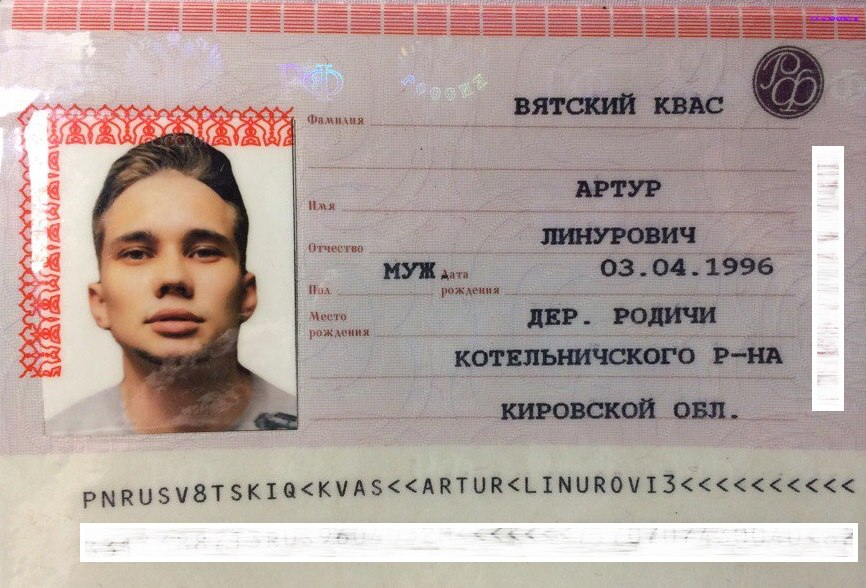

Этот документ - это российский паспорт, который содержит личную информацию об individу. Ниже приводится подробный текст, выделенный в документе:

**ВАТСКИЙ КВАС**

**Фамилия:** ВАТСКИЙ КВАС

**Имя:** АРТУР ЛИНИРОВИЧ

**Отчество:** МУЖ

**Дата рождения:** 03.04.1996

**Место рождения:** ДЕР. РОДИЧИ

**Рождение:** КОТЕЛЬНИЦКОГО Р-НА

**КИРОВСКОЙ ОЭЛ.**

**ПНРУСВ8T5K1Q<KVAS<ARTUR<LINUROVI3<<<<<<<<<<<<<<<<<<<**


Processed prompts: 100%|██████████| 1/1 [00:40<00:00, 40.70s/it, est. speed input: 13.02 toks/s, output: 87.65 toks/s]


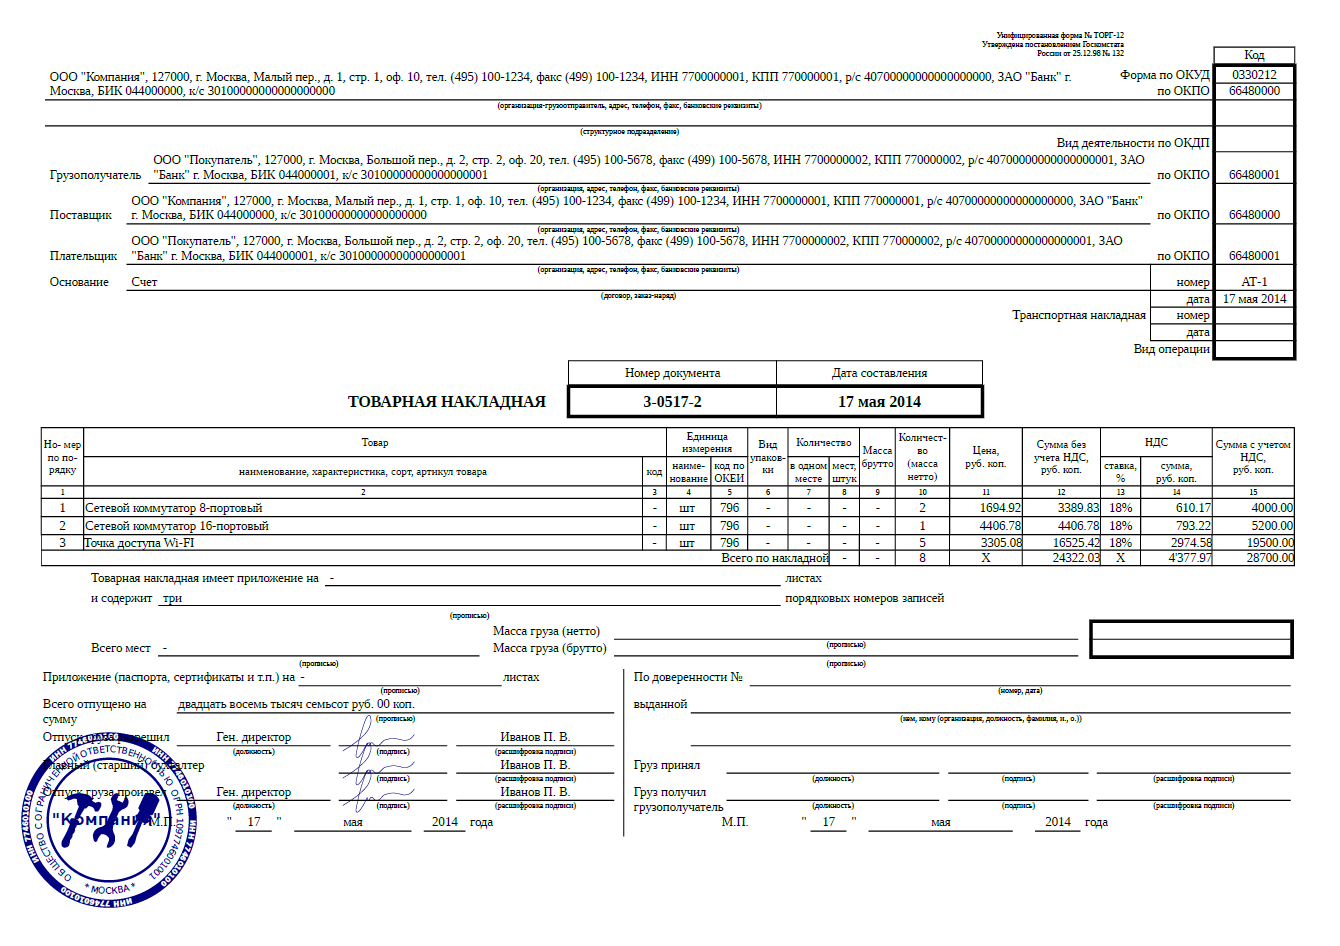

**Title:**
Товарный акт

**Header Information:**
- ООО "Компания", 127000, г. Москва, Байкальский пр., 1, стр. 1, тел. (495) 100-1234, факс (495) 100-1234, ИНН 7700000001, КПП 7700000001, п/п 4070000000000000000, ЗАО "Банк" г.
- Форма окончания по ОКУД: 0330212
- Банк: БИК 04400000, к/号码 3010000000000000000

**Address:**
- Государственное учреждение "Банк" г. Москва, Байкальский пр., 2, стр. 2, оф. 20, тел. (495) 100-5678, факс (495) 100-5678, ИНН 7700000001, п/п 4070000000000000000, ЗАО "Банк" г.

**Payment:**
- Банк: БИК 04400000, к/号码 3010000000000000000

**Date:**
- Основание: 17 Мар 2014

**Table:**
- Номер документа: 3-0517-2
- Дата составления: 17 Мар 2014
- Товар
  - Наименование: Контактная информация
  - Вид: Услуги
  - Масса (масса): 11
  - Место: 11
  - Голова: 11
  - Сумма: 1694.92
  - %: 18%
  - Стоимость: 3389.83
  - СНД: 610.17
  - СУД: 4000.00
- Ставка коммиссии 8-процент: 2
- Ставка коммиссии 16-процент: 2
- Другая доступа Wi-Fi: 1
- Общая
  - Масса (масса): 11
  - Ме

In [7]:
for filename in Path('./images').iterdir():
    inputs = {
        "prompt": prompt,
        "multi_modal_data": {
            "image": PilImage.open(filename).convert('RGB')
        },
    }
    outputs = llm.generate(inputs, sampling_params=sampling_params)

    display(Image(filename))
    for o in outputs:
        generated_text = o.outputs[0].text
        print(generated_text)
    

# Qwen2-VL

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download Qwen/Qwen2-VL-7B-Instruct

In [23]:
model_name = "Qwen/Qwen2-VL-7B-Instruct"

llm = LLM(
    model=model_name,
    max_model_len=4096,
    max_num_seqs=5,
    # Note - mm_processor_kwargs can also be passed to generate/chat calls
    mm_processor_kwargs={
        "min_pixels": 28 * 28,
        "max_pixels": 1280 * 28 * 28,
    },
)

prompt = ("<|im_start|>system\nТы ассистент, помогающий распознавать текст на изображениях.<|im_end|>\n"
          "<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>"
          f"{question}<|im_end|>\n"
          "<|im_start|>assistant\n")
stop_token_ids = None

INFO 11-11 22:48:31 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='Qwen/Qwen2-VL-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2-VL-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2-VL-7B-Instruct, num_scheduler_steps=1, chunked_prefill_enabled=False multi_step_stream_outputs=True, enab

Loading safetensors checkpoint shards:   0% Completed | 0/5 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  20% Completed | 1/5 [00:02<00:08,  2.10s/it]
Loading safetensors checkpoint shards:  40% Completed | 2/5 [00:02<00:03,  1.30s/it]
Loading safetensors checkpoint shards:  60% Completed | 3/5 [00:03<00:02,  1.04s/it]
Loading safetensors checkpoint shards:  80% Completed | 4/5 [00:04<00:00,  1.09it/s]
Loading safetensors checkpoint shards: 100% Completed | 5/5 [00:04<00:00,  1.48it/s]
Loading safetensors checkpoint shards: 100% Completed | 5/5 [00:04<00:00,  1.10it/s]



INFO 11-11 22:48:38 model_runner.py:1067] Loading model weights took 15.5008 GB
WARNING 11-11 22:48:38 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-11 22:48:38 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-11 22:48:38 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-11 22:48:38 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-11 22:48:38 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
WARNING 11-11 22:48:38 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}
INFO 11-11 22:

In [24]:
sampling_params = SamplingParams(temperature=0,
                                     max_tokens=None,
                                     stop_token_ids=stop_token_ids)

WARNING 11-11 22:48:43 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-11 22:48:43 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.88s/it, est. speed input: 362.10 toks/s, output: 67.93 toks/s]


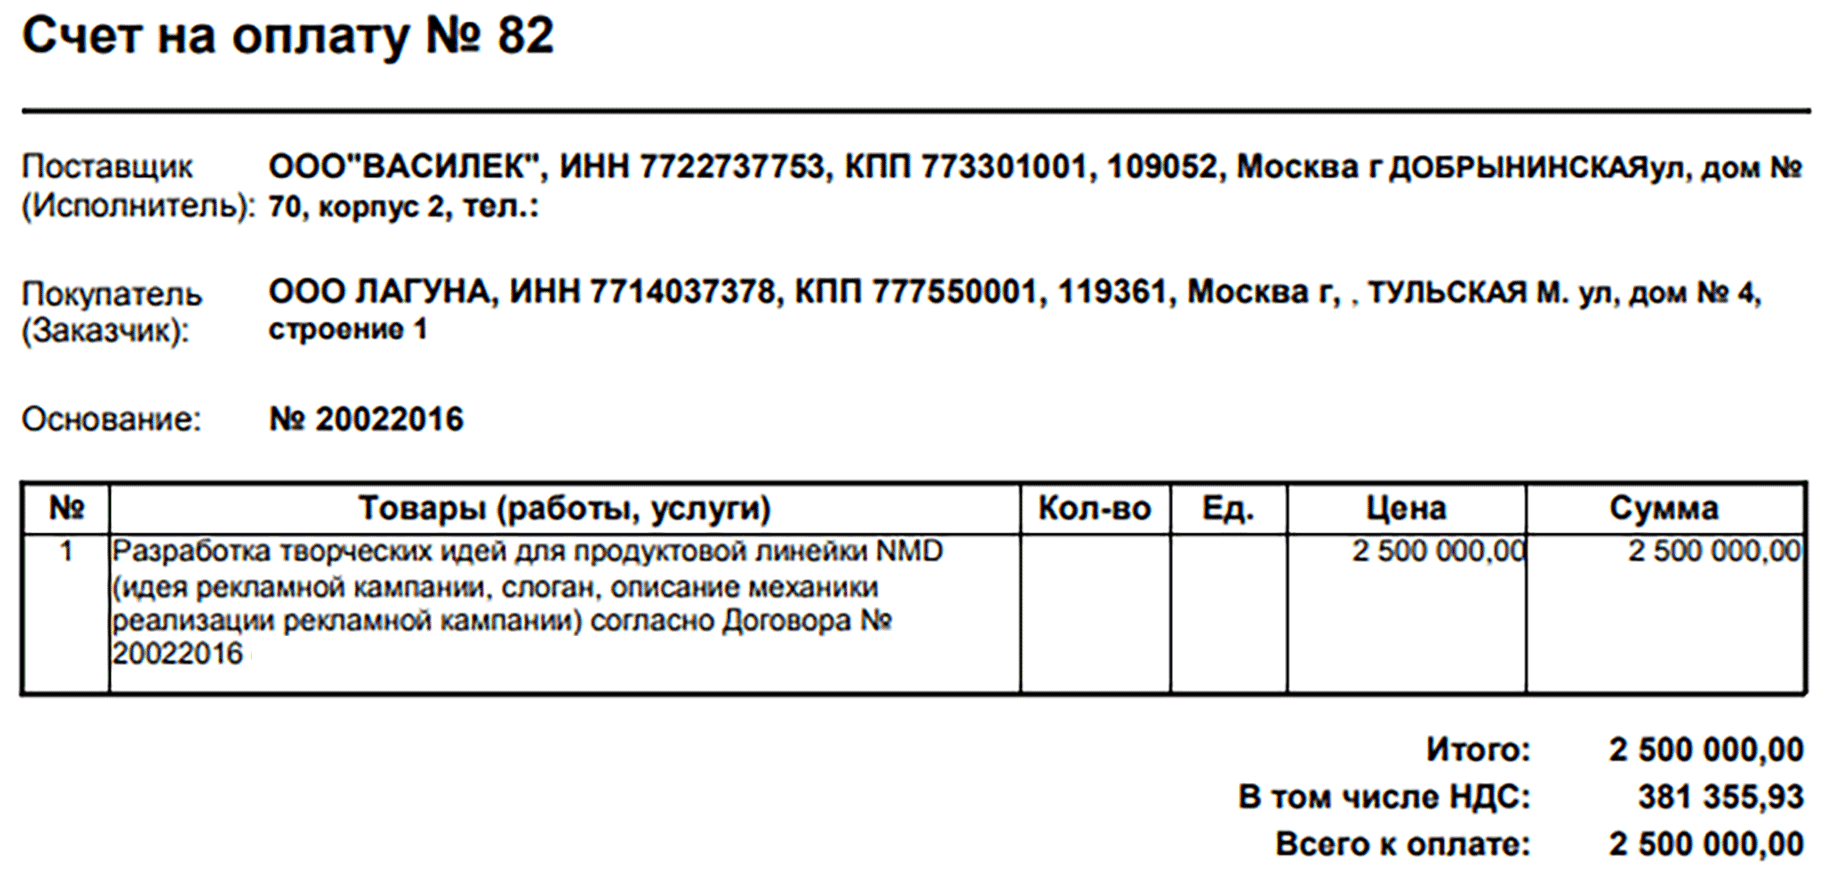

### Счет на оплату № 82

| Статья | Товары (работы, услуги) | Кол-во | Ед. | Цена | Сумма |
| --- | --- | --- | --- | --- | --- |
| 1 | Разработка творческих идей для продуктной линейки NMD (идея рекламной кампании, слоган, описание механики реализации рекламной кампании) согласно Договора № 20022016 | 1 |  | 2 500 000,00 | 2 500 000,00 |

### Общая сумма:
- Итого: 2 500 000,00
- В том числе НДС: 381 355,93
- Всего к оплате: 2 500 000,00

### Поставщик:
- ООО "ВАСИЛЕК", ИНН 7722737753, КПП 773301001, 109052, Москва г ДОБРЫНИНСКАЯ ул, дом № 70, корпус 2, тел.:

### Покупатель:
- ООО ЛАГУНА, ИНН 7714037378, КПП 777550001, 119361, Москва г, ТУЛЬСКАЯ М. ул, дом № 4, строение 1

### Основание:
- № 20022016
WARNING 11-11 22:48:49 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-11 22:48:49 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it, est. speed input: 337.16 toks/s, output: 76.46 toks/s]


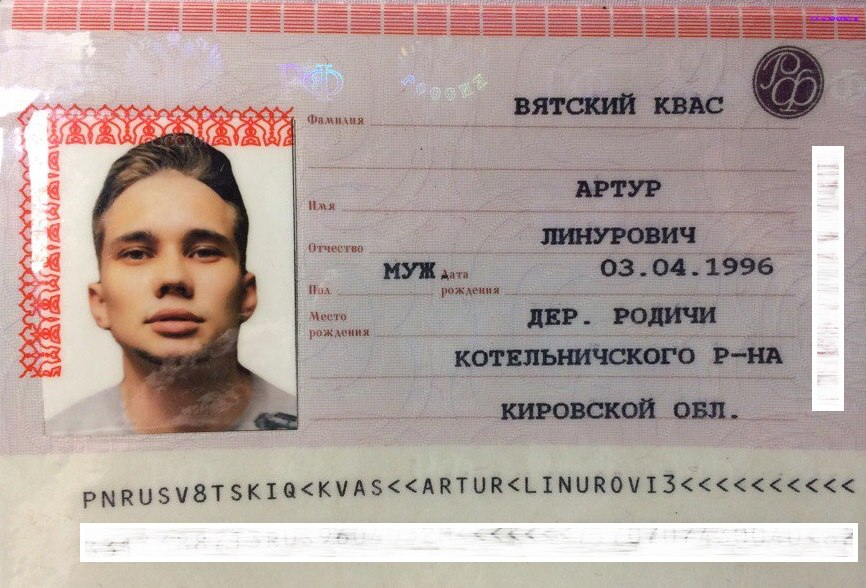

Вот извлеченный текст изображения:

| Структурированная информация | Текст |
| --- | --- |
| Фамилия | ВЯТСКИЙ КВАС |
| Имя | АРТУР |
| Отчество | ЛИНУРОВИЧ |
| Дата рождения | 03.04.1996 |
| Пол | МУЖ |
| Место рождения | ДЕР. РОДИЧИ КОТЕЛЬНИЧЕСКОГО Р-НА КИРОВСКОЙ ОБЛ. |
| Символы | PNRUSV8TSKIQ<KVAS<<ARTUR<LINUROVI3<<<<< |
WARNING 11-11 22:48:51 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 11-11 22:48:51 utils.py:1401] The following intended overrides are not keyword-only args and and will be dropped: {'min_pixels', 'max_pixels'}


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it, est. speed input: 254.69 toks/s, output: 76.12 toks/s]


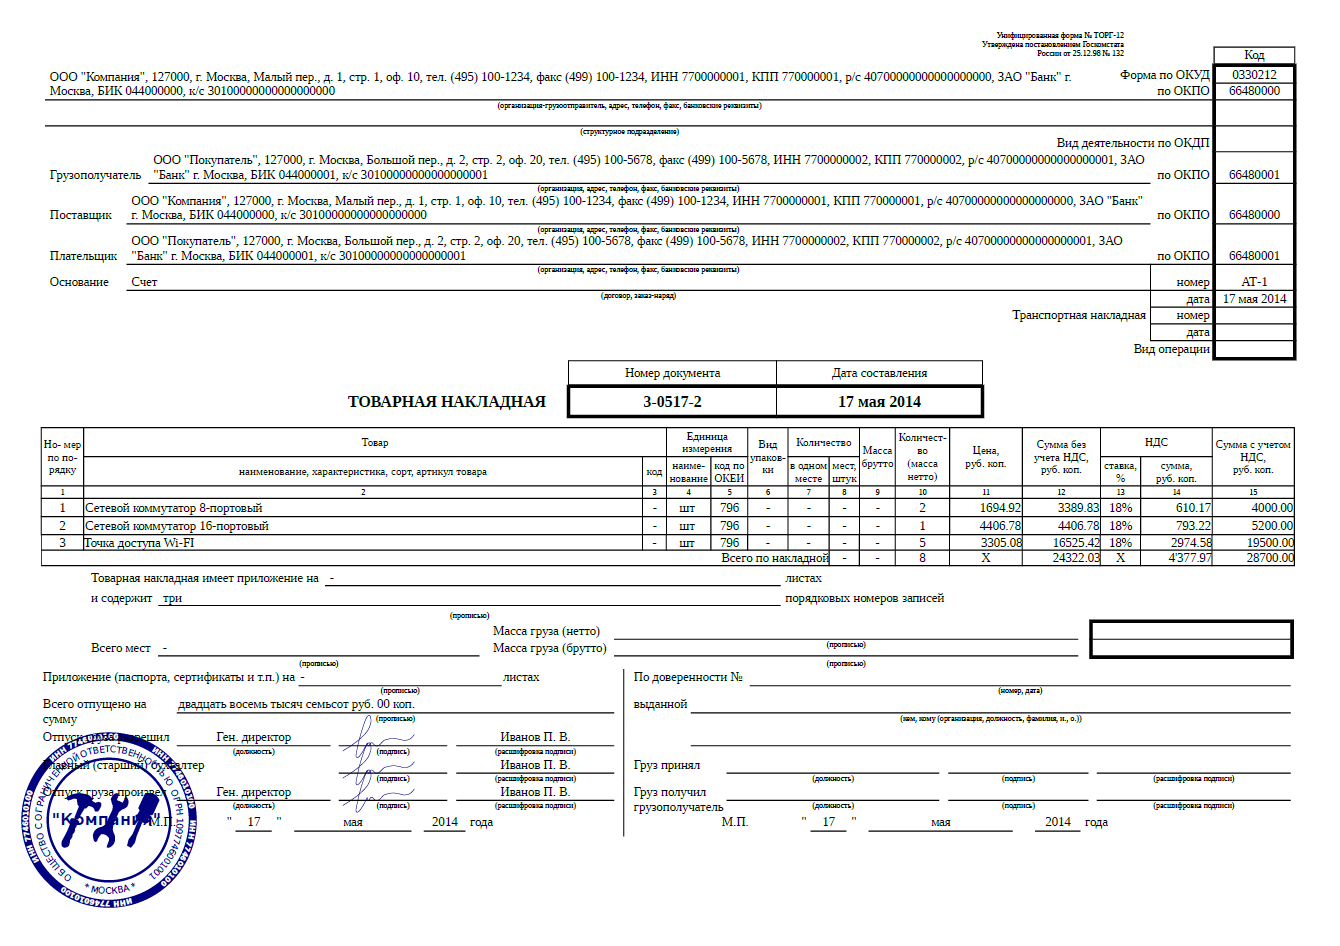

### Товарная накладная

#### Основные данные
- Форма ОКУД: 0330212
- Форма ОКПО: 66480000
- Вид деятельности по ОКДП: 66480001
- Вид операции: Транспортная накладная
- Дата составления: 17 мая 2014
- Номер документа: 3-0517-2

#### Товары
| № по порядку | Товар | Единица измерения | Количество | Масса брутто | Цена, руб. | Сумма без НДС, руб. | Сумма с НДС, руб. |
|--------------|-------|--------------------|-------------|--------------|------------|-------------------|------------------|
| 1            | Сетевой коммутатор 8-портовый | шт | 2 | - | 1694.92 | 3389.83 | 4000.00 |
| 2            | Сетевой коммутатор 16-портовый | шт | 1 | - | 4406.78 | 4406.78 | 793.22 |
| 3            | Точка доступа Wi-Fi | шт | 5 | - | 3305.08 | 16525.42 | 19500.00 |

#### Общая сумма
- Всего по накладной: 24322.03 руб.

#### Подписи
- Отпуск груза произвел: Ген. директор Иванов П. В.
- Груз принял: (подпись)
- Груз получил: (подпись)

#### Дополнительные данные
- Унифицированная форма № ТОРГ-12
- Утв

In [25]:
for filename in Path('./images').iterdir():
    inputs = {
        "prompt": prompt,
        "multi_modal_data": {
            "image": PilImage.open(filename).convert('RGB')
        },
    }
    outputs = llm.generate(inputs, sampling_params=sampling_params)

    display(Image(filename))
    for o in outputs:
        generated_text = o.outputs[0].text
        print(generated_text)
    

# Pixtral

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download mistral-community/pixtral-12b

Loading checkpoint shards: 100%|██████████| 6/6 [00:15<00:00,  2.55s/it]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


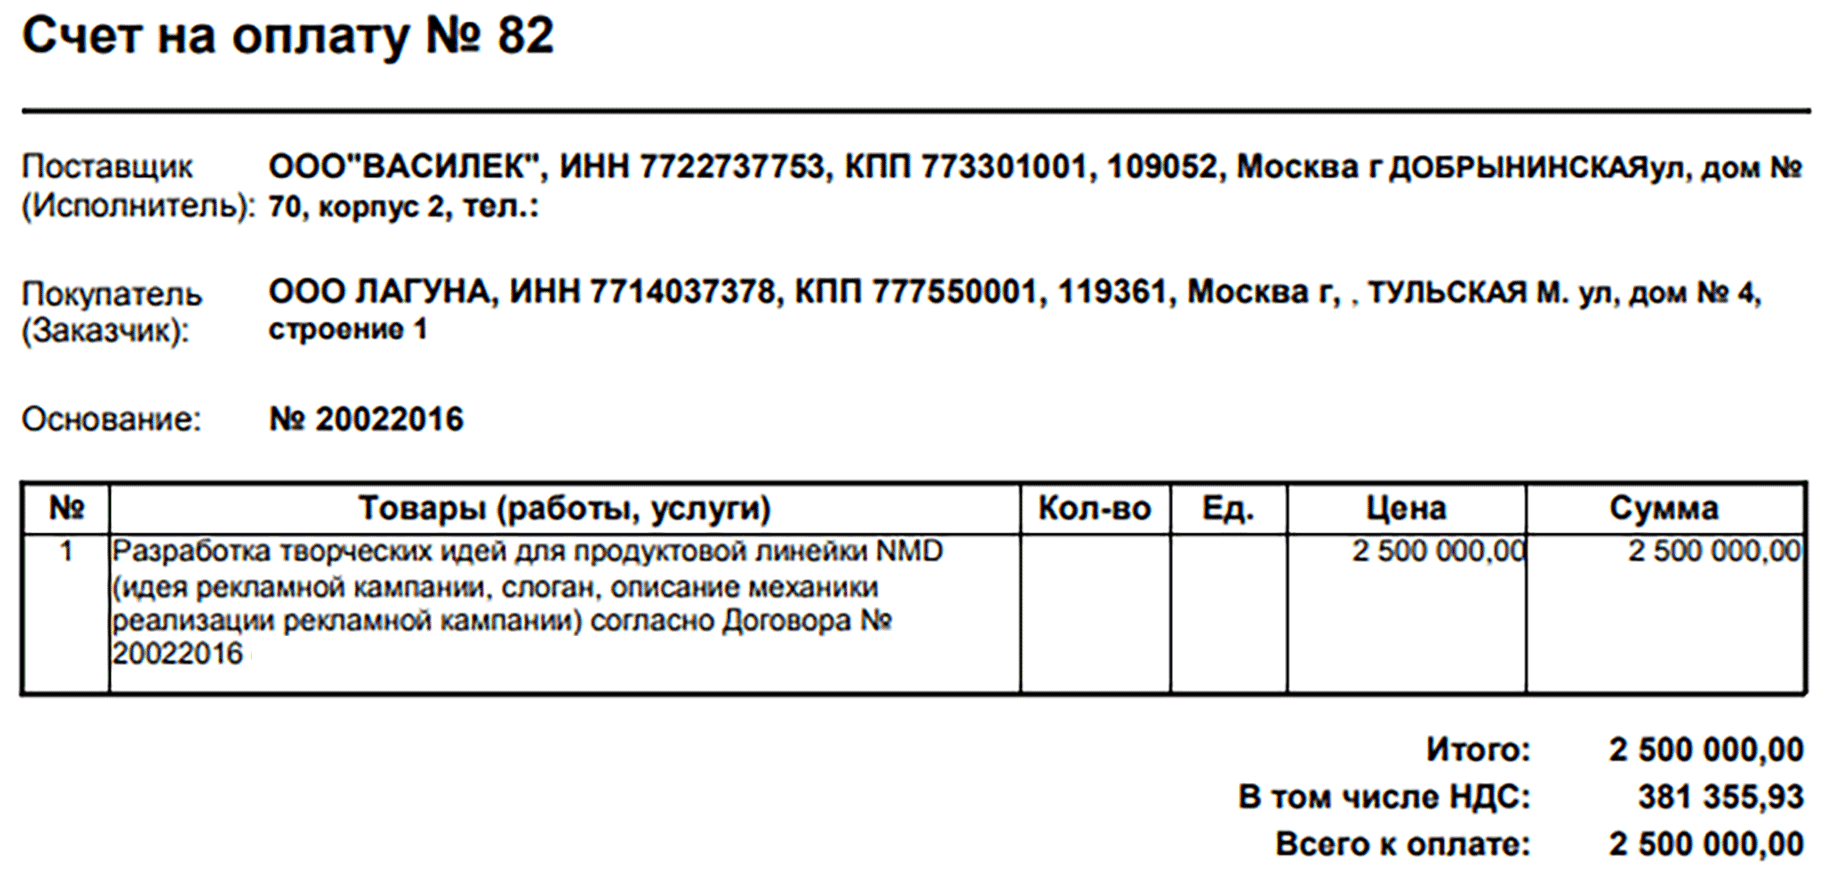

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы..
Конечно, вот анализ и извлечение текста из изображения в виде таблицы:

### Счет на оплату № 82

| **Поставщик** (Исполнитель): | ООО "ВАСИЛЕК", ИНН 7722737753, КПП 773301001, 109052, Москва г ДОБРЫНИНСКАЯ ул, дом № 70, корпус 2, тел.: |
|--------------------------------|----------------------------------------------------------------------------------------------------------|
| **Покупатель** (Заказчик): | ООО ПАГУНА, ИНН 7714037378, КПП 777550001, 119361, Москва г., ТУЛЬСКАЯ М. ул, дом № 4, строение 1 |

| **Основание:** | № 20022016 |

| **№** | **Товары (работы, услуги)** | **Кол-во** | **Ед.** | **Цена** | **Сумма** |
|--------|--------------------------------|----------|------|--------|----------|
| 1      | Разработка творческих идей для продуктовой линии NMD (идея рекламной кампании, слоган, описание механики реализ

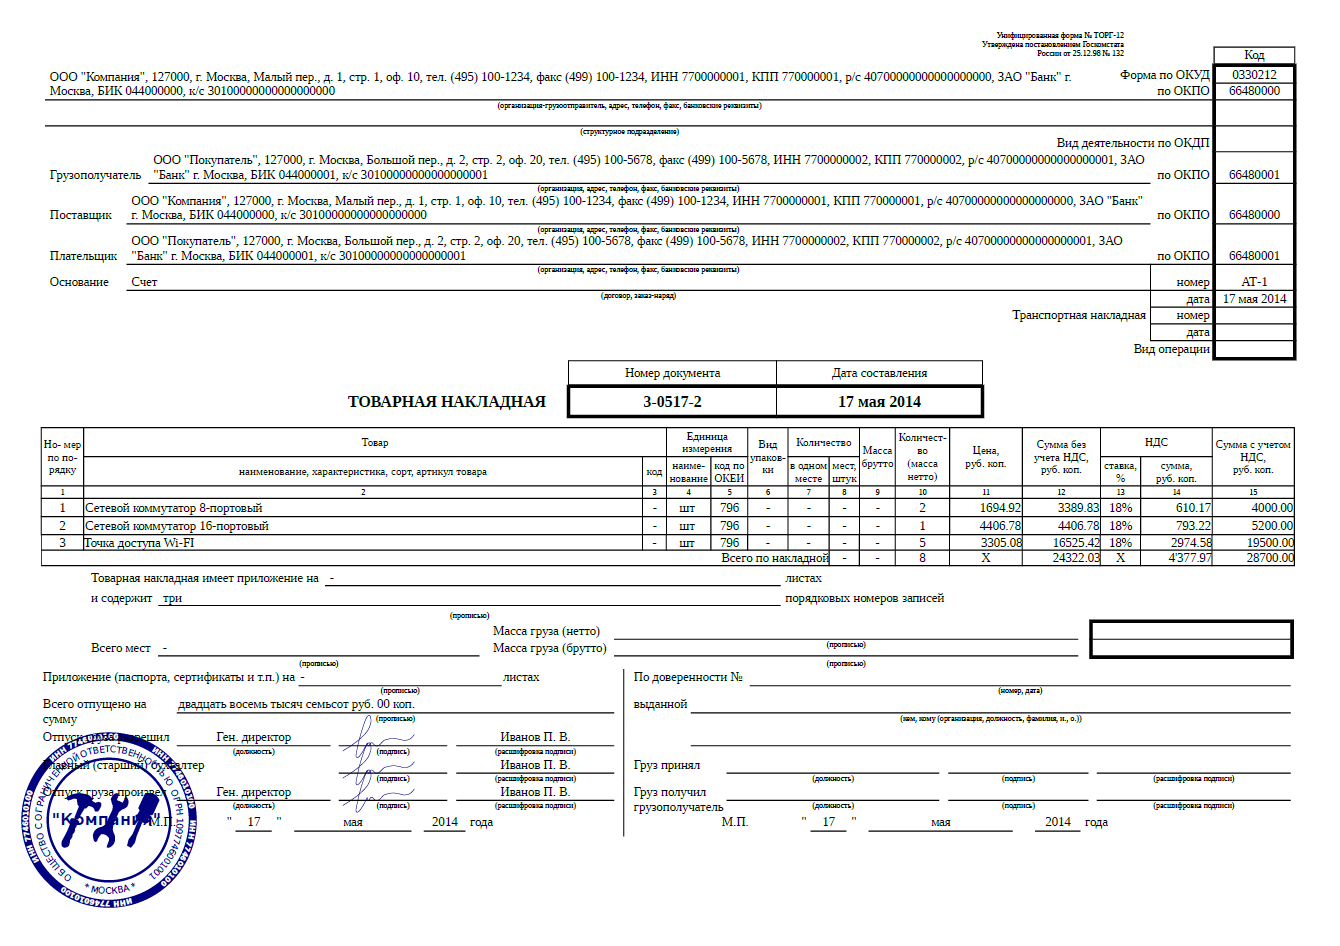

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы..
Конечно, вот анализ изображения и извлеченный текст в виде таблицы:

### Таблица 1: Информация о документе

| Поле                          | Значение                                                                 |
|-------------------------------|--------------------------------------------------------------------------|
| Наименование документа         | Товарная накладная                                                      |
| Номер документа                | 3-0517.2                                                                 |
| Дата составления               | 17 мар 2014                                                             |
| Поставщик                     | ООО "Коммунист", г. Москва, Машиностроительная ул., д. 1, стр. 1, оф. 10, р/с (405) 100-1234, БИК (405) 100-1234, ИНН 77000000001, КПП 7700000001, 

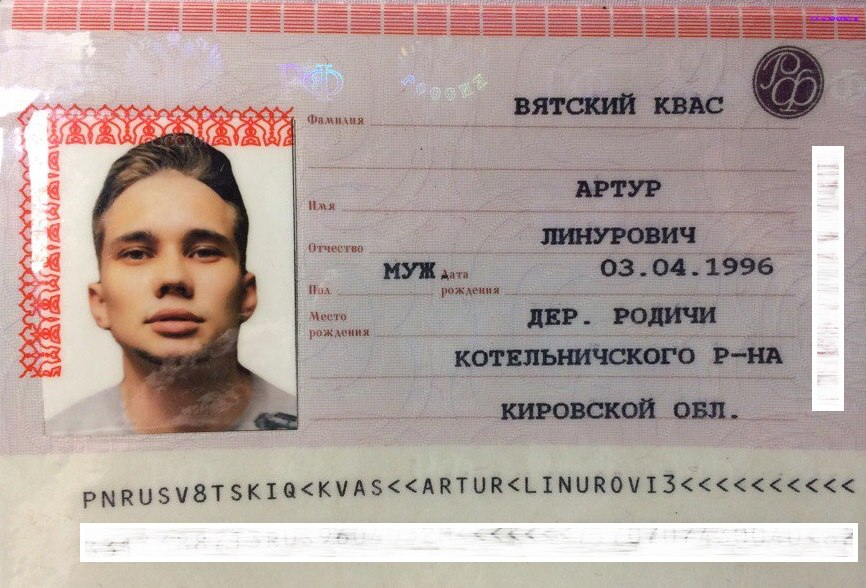

Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы..
Конечно, вот извлеченная информация из изображения в виде таблицы:

| Поле                  | Значение                          |
|-----------------------|-----------------------------------|
| Имя                    | Артур                             |
| Фамилия                | Линурович                          |
| Отчество               | Мук                                 |
| Дата рождения          | 03.04.1996                         |
| Пол                    | Мужской                            |
| Гражданство            | Дер. Родичи                        |
| Место рождения         | Котельничского р-на Кировской обл.  |

Эта таблица включает основную информацию, извлеченную из изображения.


In [50]:
model_id = "mistral-community/pixtral-12b"
model = LlavaForConditionalGeneration.from_pretrained(model_id)
model = model.to('cuda')
processor = AutoProcessor.from_pretrained(model_id)

imgs = [
PilImage.open("./images/4-blankscheta-new.png"),
PilImage.open("./images/blank-torg12-03.png"), 
PilImage.open("./images/img-48999-15003795646755.jpg"), 
]
PROMPT = f"<s>[INST]{question}.\n[IMG][/INST]"

for img in imgs:
    inputs = processor(text=PROMPT, images=[img], return_tensors="pt").to("cuda")
    generate_ids = model.generate(**inputs, max_new_tokens=4000,  temperature=0)
    output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    display(img)
    print(output)

# PaliGemma

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download merve/paligemma_vqav2

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.64s/it]
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


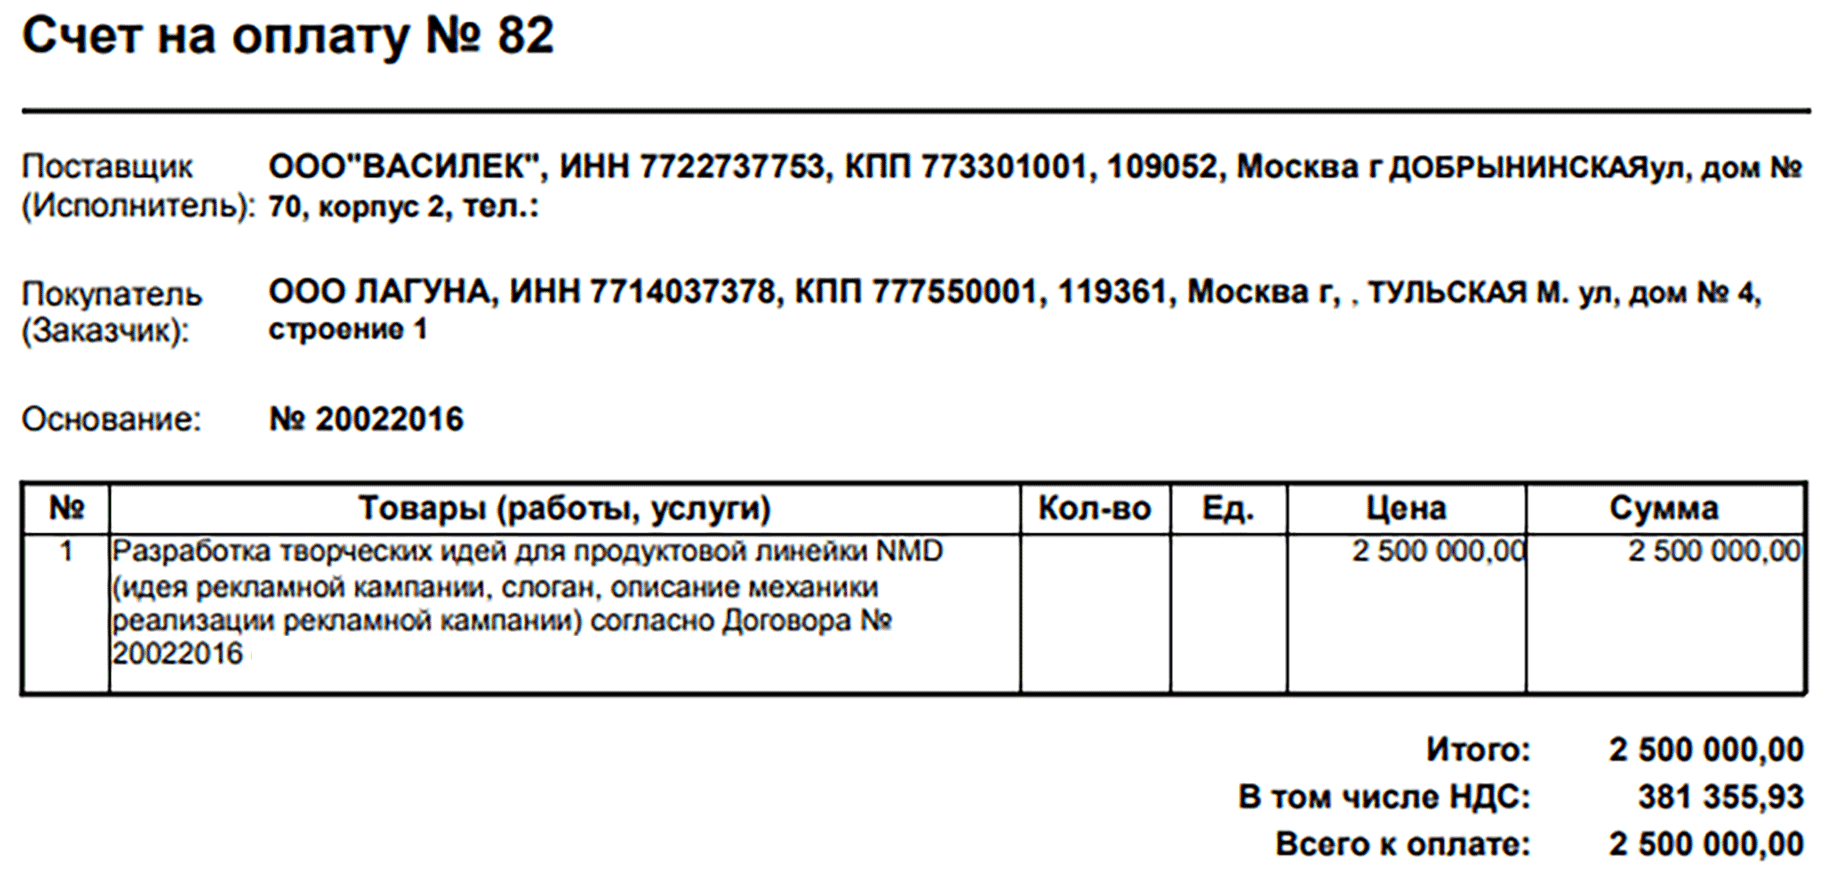

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы.
Счет на оплату № 82
ООО"ВАСИЛЕЦ", ИНН 7722237762, КПП 772201001, 109052, Москва / ДОБРЫНИНСКИЙ ул, дом № 67, квартира 70, корпус 2, тел.:
ООО "ВАГИНА", ИНН 7714237378, КПП 777550001, 119381, Москва с., ТУЛЬСКАЯ М., ул. дом № 4,
страница 1
Основание: № 20022016
№
Товары (работы, услуги)
Кол-во Ед.
Цена
Сумма
1
Разработка программного для генеральной канцелярии МКО
2 500 000,00
2 500 000,00
2 500 000,00
Договора №
381 000,65
Всего к оплате:


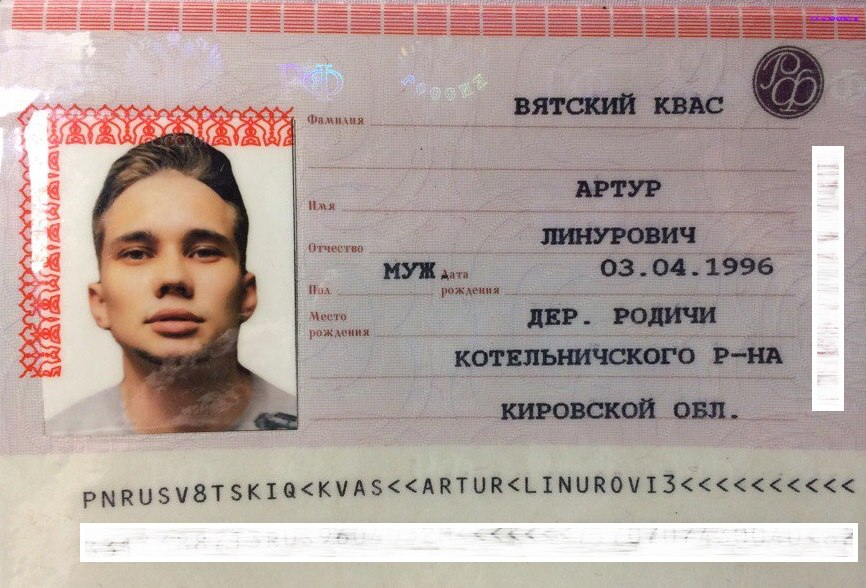

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы.
ВТСКИЙ КВАС
Фамилия
АРТУР
Имя
Дмитрович
Отчество
03.04.1996
03.04.1996
Год
Дата рождения
дер. родич
КОТЕЛЬНИЧСКОГО Р-НА
Кировской обл.
PNRUSV8TSKIOKVAS<KARTORLINUROV13<<<<<<<<<<


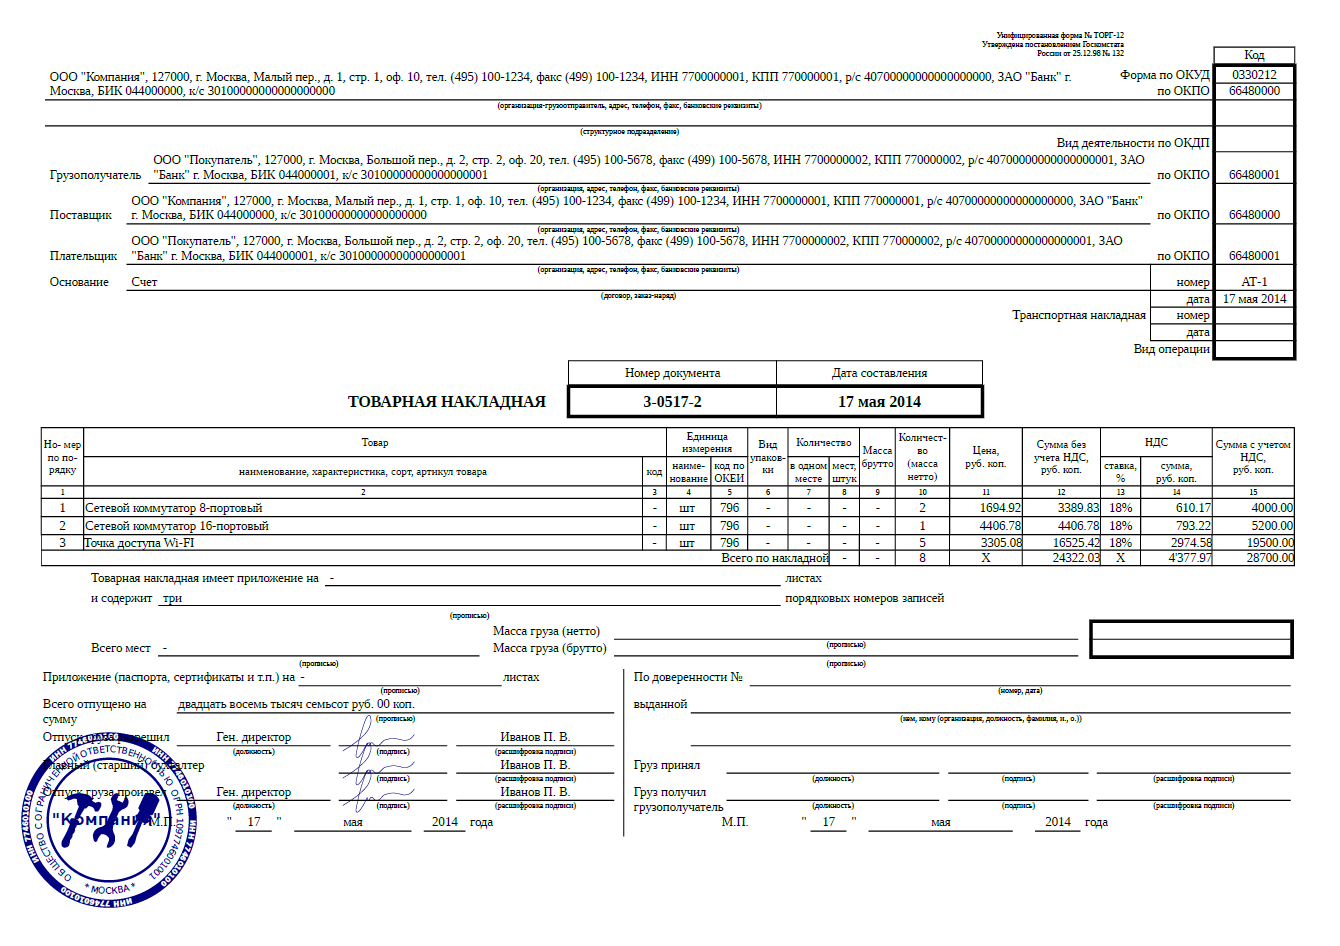

Проанализируй изображение и извлеки весь текст, включая структурированную информацию.
Сделай это максимально точно и представь результат в виде списка или таблицы.
Сумма наличных
10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [19]:
model_id = "merve/paligemma_vqav2"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id).to('cuda')
processor = AutoProcessor.from_pretrained("google/paligemma-3b-pt-224")

prompt = question
for filename in Path('./images/').iterdir():
    image = PilImage.open(filename)
    
    inputs = processor(prompt, image.convert("RGB"), return_tensors="pt").to('cuda')
    output = model.generate(**inputs, max_new_tokens=1000)
    display(image)
    print(processor.decode(output[0], skip_special_tokens=True))


# Llava Saiga

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download deepvk/llava-saiga-8b

Loading checkpoint shards: 100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


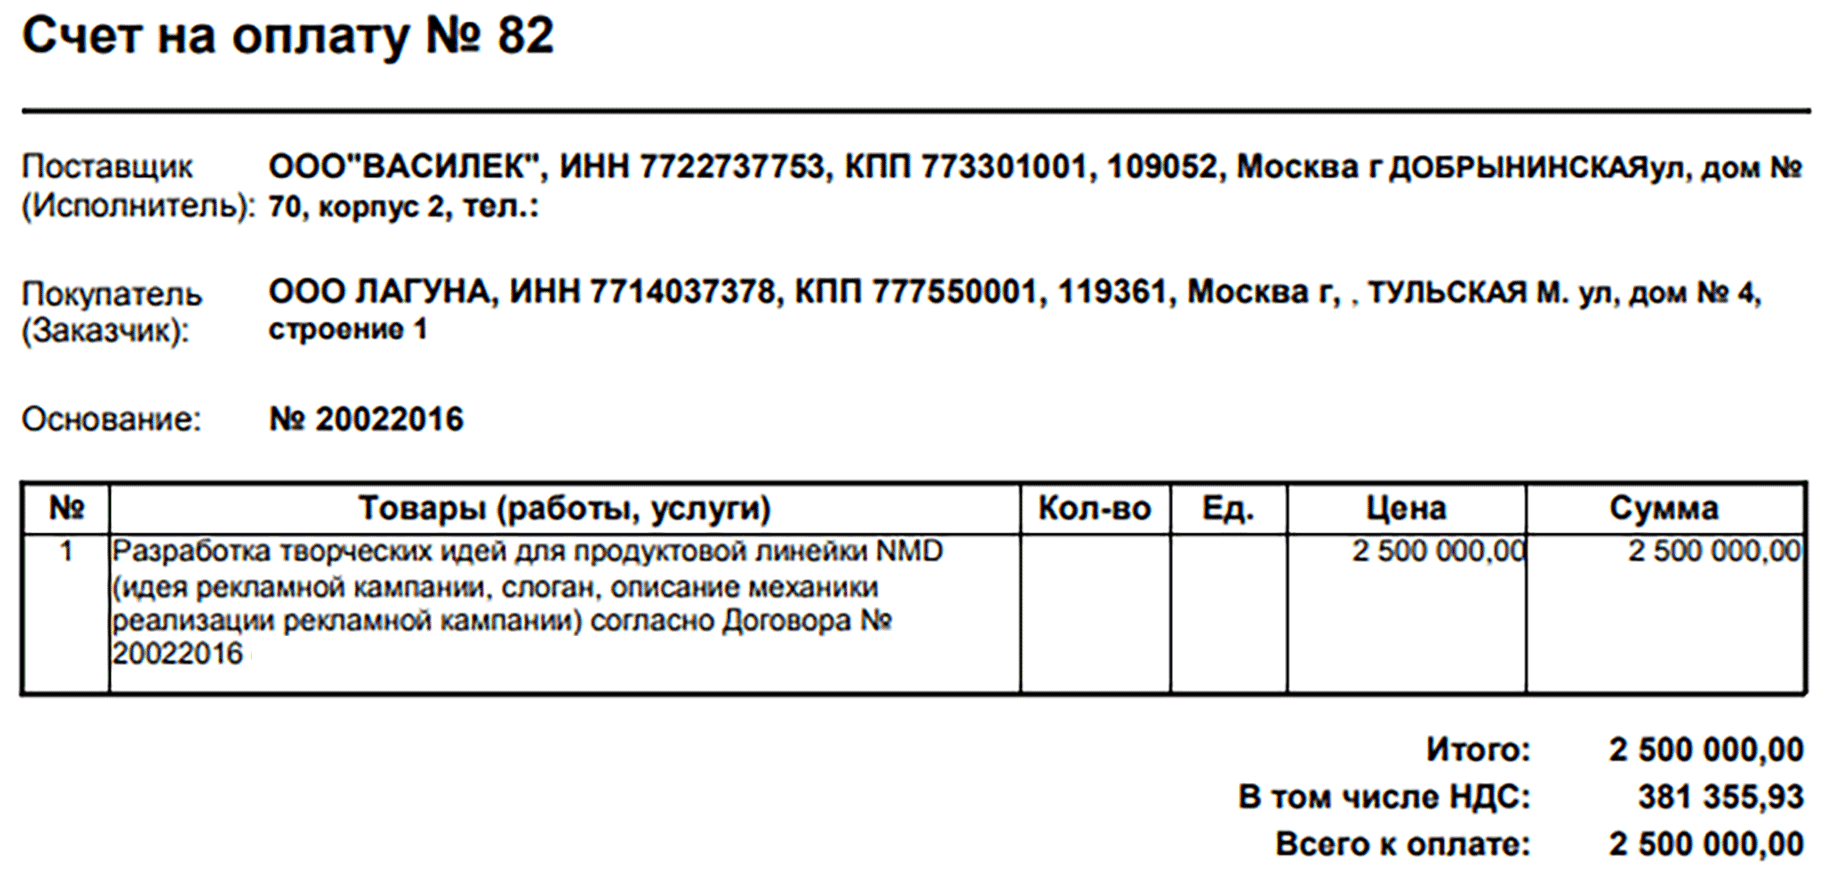

На изображении представлен текст на русском языке, который, вероятно, является частью какого-то официального документа или инструкции. Текст содержит информацию о различных странах, возможно, это список стран или географические координаты. В тексте также упоминается "Контрольная точка" и "Контрольная точка", что может указывать на контрольные пункты или точки наблюдения. Текст выглядит структурированным и организованным, что может свидетельствовать о его официальном или информационном характере.


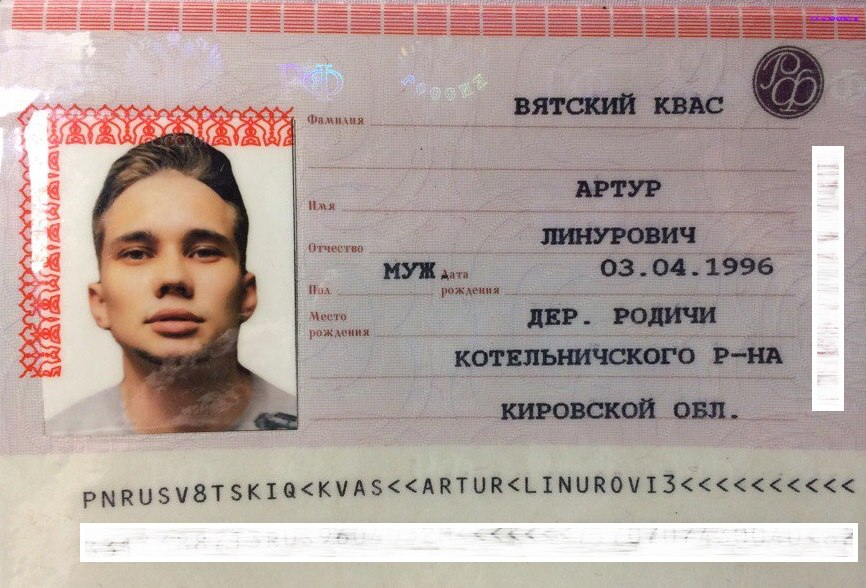

На изображении представлен паспорт, который принадлежит мужчине с именем Артем. Паспорт имеет серый цвет и на нем изображен мужчина с бородой. На нем также присутствует фотография мужчины. На задней стороне паспорта есть информация о том, что он был выдан в России. Также на паспорте есть информация о том, что он был выдан в 2019 году.


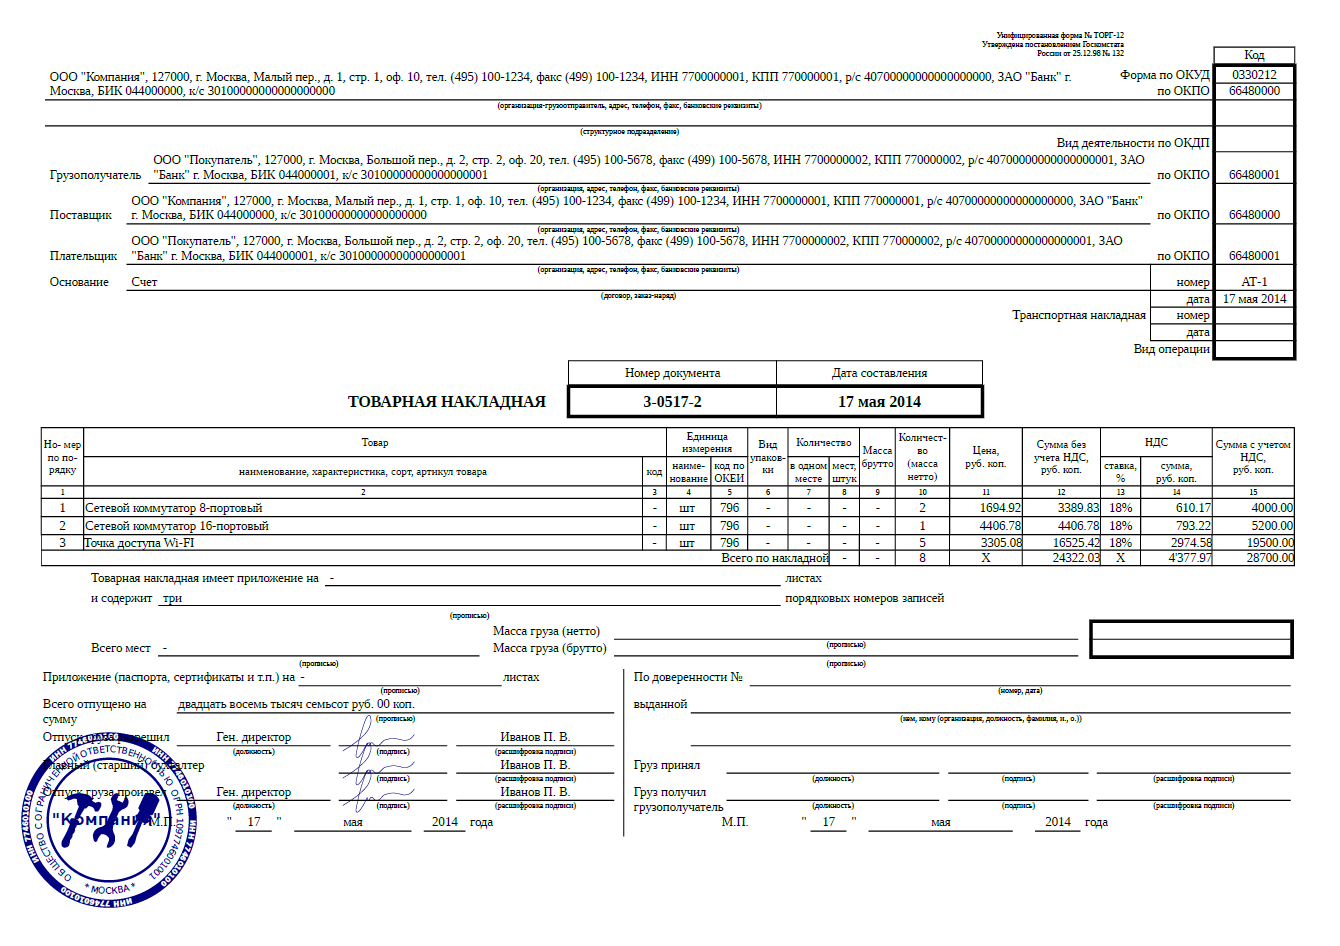

На изображении представлен документ, напоминающий документы, связанные с образованием. На нем есть текст на русском языке, который, вероятно, содержит информацию о студентах. Возможно, это документ о выпускном балансе или другом образовательном документе. Текст на документе выглядит как структурированная информация, что может указывать на то, что это официальное документальное письмо или отчет.


In [26]:
model_name = "deepvk/llava-saiga-8b"

model = LlavaForConditionalGeneration.from_pretrained(model_name).to('cuda')
processor = AutoProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

for filename in Path('./images/').iterdir():
    messages = [
        {"role": "user", "content": f"<image>\n{question}"}
    ]
    img = PilImage.open(filename)
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(images=[img], text=text, return_tensors="pt").to('cuda')
    
    generate_ids = model.generate(**inputs, max_new_tokens=1000)
    answer = tokenizer.decode(generate_ids[0, inputs.input_ids.shape[1]:], skip_special_tokens=True)
    display(img)
    print(answer)


# Phi-3

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download microsoft/Phi-3-vision-128k-instruct

In [40]:
prompt = f"<|user|>\n<|image_1|>\n{question}<|end|>\n<|assistant|>\n" 
llm = LLM(
        model="microsoft/Phi-3-vision-128k-instruct",
        trust_remote_code=True,
        max_model_len=4096
        max_num_seqs=2,
        mm_processor_kwargs={"num_crops": 16},
    )
stop_token_ids = None

INFO 11-12 00:14:56 config.py:107] Replacing legacy 'type' key with 'rope_type'
WARNING 11-12 00:14:56 config.py:114] Replacing legacy rope_type 'su' with 'longrope'
INFO 11-12 00:14:56 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='microsoft/Phi-3-vision-128k-instruct', speculative_config=None, tokenizer='microsoft/Phi-3-vision-128k-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_ti

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.28it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.43it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:01<00:00,  1.40it/s]



INFO 11-12 00:15:00 model_runner.py:1067] Loading model weights took 7.8855 GB
INFO 11-12 00:15:01 gpu_executor.py:122] # GPU blocks: 11096, # CPU blocks: 682
INFO 11-12 00:15:01 gpu_executor.py:126] Maximum concurrency for 4096 tokens per request: 43.34x
INFO 11-12 00:15:01 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-12 00:15:01 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-12 00:15:03 model_runner.py:1523] Graph capturing finished in 2 secs.


In [41]:
sampling_params = SamplingParams(temperature=0,
                                     max_tokens=None,
                                     stop_token_ids=stop_token_ids)

prompt_token_ids (old) [1, 32010, 29871, 13, 29966, 29989, 3027, 29918, 29896, 29989, 29958, 13, 30013, 576, 14611, 644, 1916, 1086, 29977, 1866, 15124, 11567, 606, 1866, 29942, 753, 717, 3340, 1210, 23567, 464, 29892, 20352, 29970, 22675, 21663, 11866, 6627, 25565, 13603, 29889, 13, 30008, 12761, 29977, 6408, 2394, 11153, 1155, 11372, 2721, 4913, 606, 11876, 29978, 13439, 29932, 490, 21986, 27768, 2494, 7082, 1710, 5116, 10566, 29889, 32007, 29871, 13, 32001]


Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it, est. speed input: 356.12 toks/s, output: 97.58 toks/s]


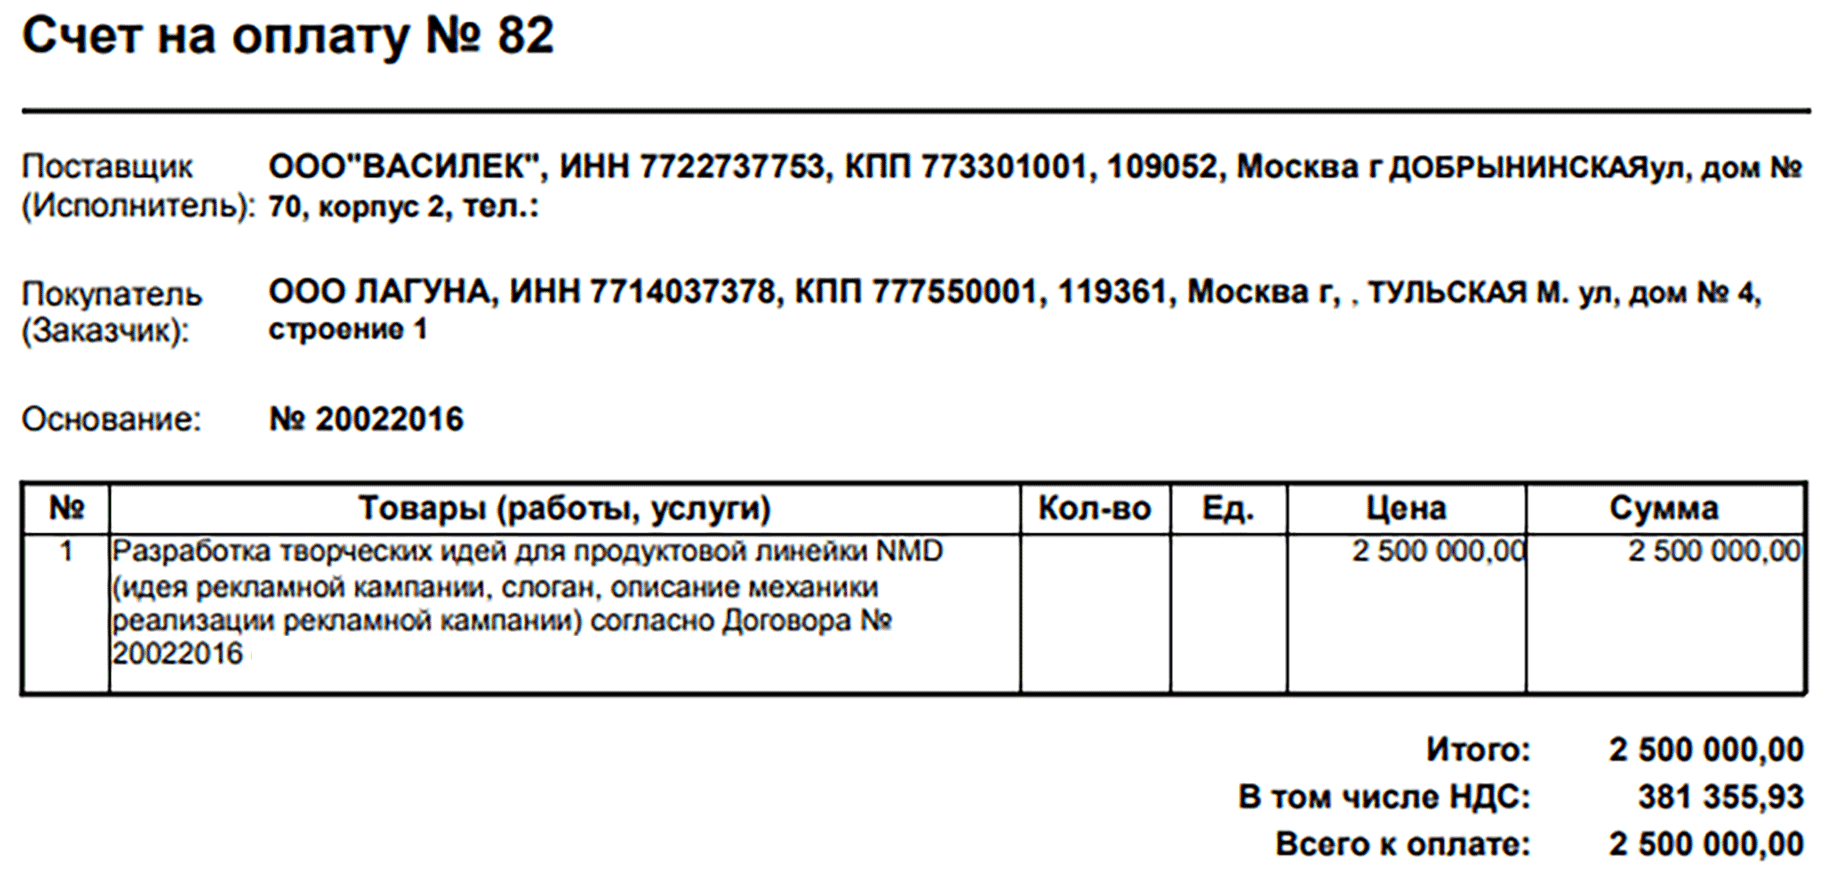

 The image contains a document titled "Счет на оплату № 82" which translates to "Account for Payment No. 82". The document is in Russian and appears to be a financial statement or invoice. The document is divided into several sections with headings and subheadings.

The first section is titled "Поставщик" which translates to "Supplier" and lists the name "ООО"ВАСИЛЕК" (OOO VASILEK), an INN number, a company registration number, a tax number, and a location in Moscow. The supplier's name is in Cyrillic script.

The second section is titled "Покупатель" which translates to "Customer" and lists the name "ООО ЛАГУНА" (OOO LAGUNA), an INN number, a company registration number, a tax number, and a location in Moscow. The customer's name is in Cyrillic script.

The third section is titled "Основание" which translates to "Invoice" and lists the number "№ 20022016".

The fourth section is a table with the following columns: "№" (No.), "Товары (работы, услуги)" (Products (work, services)), "Кол-

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it, est. speed input: 753.67 toks/s, output: 101.80 toks/s]


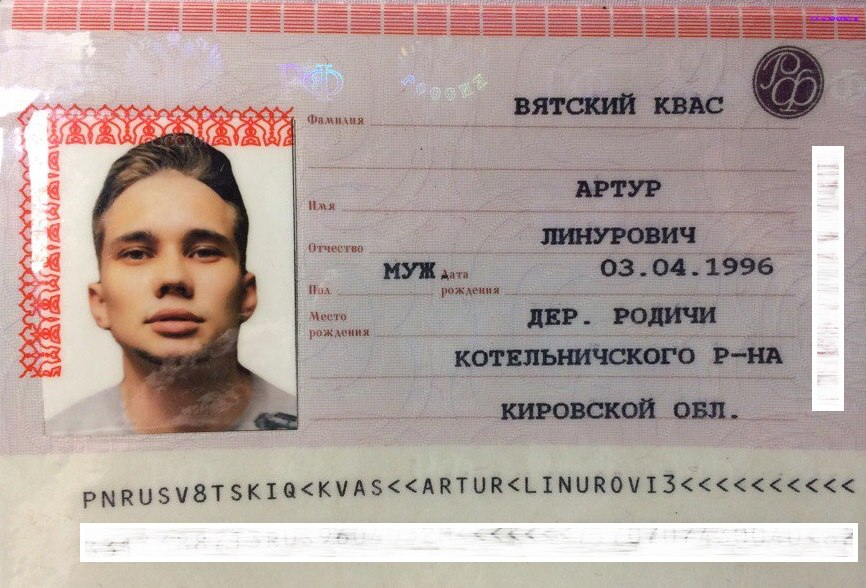

 The image shows a document with a red and white border at the top and bottom. The document is titled "ВАТСКИЙ КВАС" which translates to "BATTLE KWAC". Below the title, there is a section labeled "АРТУР" which translates to "ART". The next section is labeled "ЛИНУРОВИЧ" which translates to "LINUROVIC". The date "03.04.1996" is mentioned, followed by the name "ДЕР. РОДИЧИ" which translates to "DEAD MAN". The document is from the "КОТЕЛЬНИЧСКОГО Р-НА" which translates to "CENTRAL REGISTRY" and the "КИРОВСКОЙ ОБЩ." which translates to "CHURCH". There is a barcode with the numbers "PNRUSV8TSKIQ<KVAS<ARTUR<LINUROV13" below it. The document appears to be a form or certificate related to a deceased individual, possibly for a religious or official purpose.
prompt_token_ids (old) [1, 32010, 29871, 13, 29966, 29989, 3027, 29918, 29896, 29989, 29958, 13, 30013, 576, 14611, 644, 1916, 1086, 29977, 1866, 15124, 11567, 606, 1866, 29942, 753, 717, 3340, 1210, 23567, 464, 29892, 20352, 29970, 22675, 2

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it, est. speed input: 821.42 toks/s, output: 101.02 toks/s]


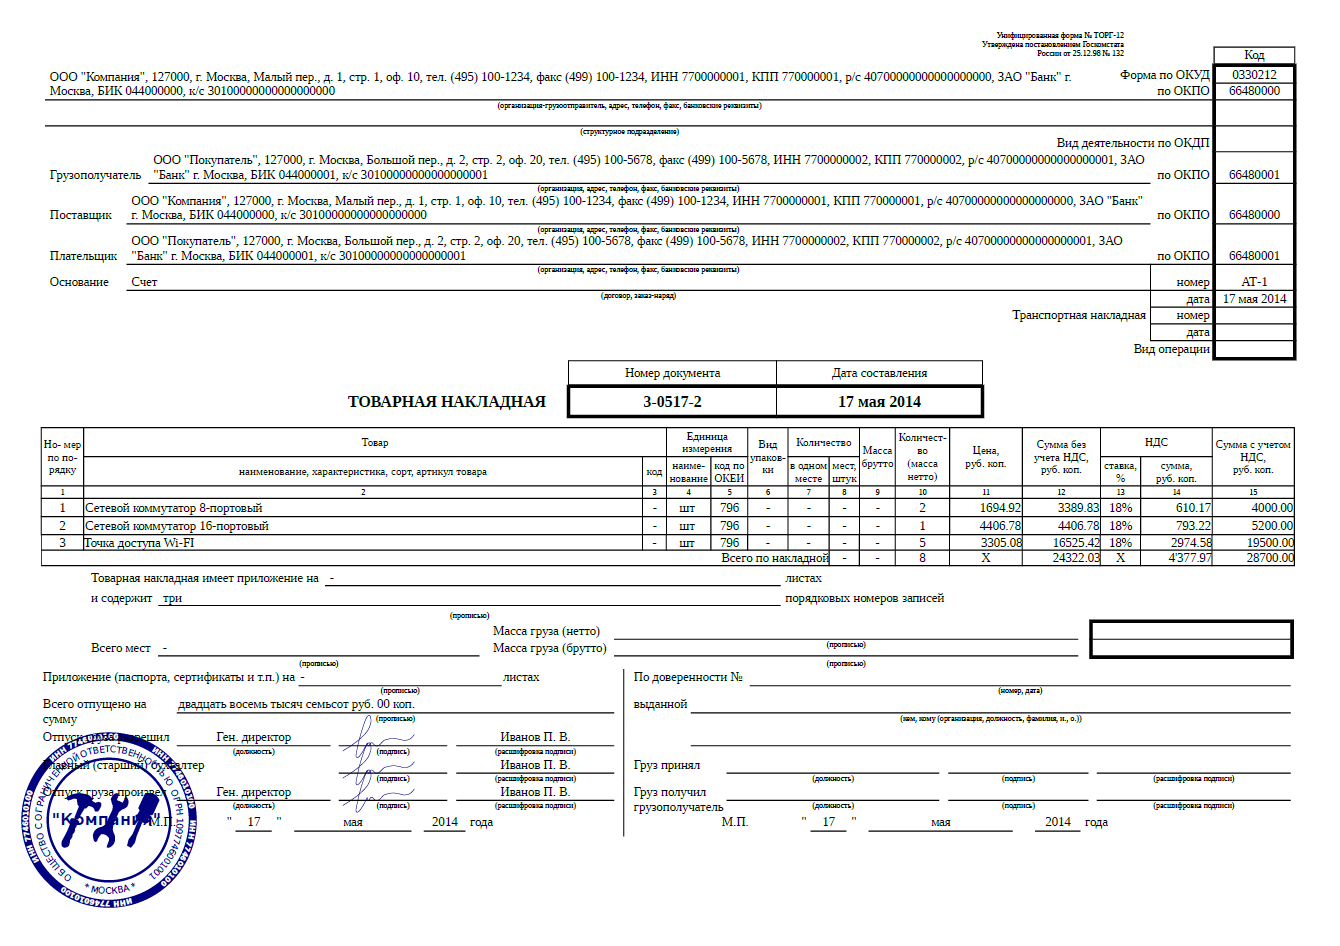

 The image contains a document with various sections and text in Russian. The document appears to be a financial or accounting report, possibly related to a company named "ООО 'Компания'" with a registration number and other details provided. The document includes sections for 'Произношение' (Distribution), 'Товарная накладная' (Tax Deduction), and 'Приложение' (Attachment), with specific figures and percentages listed under each. There are also sections for 'Весo по налождению' (Weight of Tax Deduction) and 'Весo по оцение номера' (Weight of Tax Deduction per Unit). The document is structured with tables and lists, and there are references to 'Вата' (Tax) and 'Сумма' (Total). The bottom of the document includes a logo with the text 'КОММИНИ' and a date '17 мая 2014'. The text is dense and contains specific financial data, which would require a detailed understanding of Russian accounting practices to fully interpret.


In [42]:
for filename in Path('./images/').iterdir():
    inputs = {
        "prompt": prompt,
        "multi_modal_data": {
            "image": PilImage.open(filename).convert('RGB')
        },
    }
    outputs = llm.generate(inputs, sampling_params=sampling_params)

    display(Image(filename))
    for o in outputs:
        generated_text = o.outputs[0].text
        print(generated_text)
    

# Molmo

In [ ]:
!HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download  allenai/Molmo-7B-D-0924

In [61]:
model_name = 'allenai/Molmo-7B-D-0924'
llm = LLM(
        model=model_name,
        trust_remote_code=True,
        dtype="bfloat16",
    )

prompt = question
stop_token_ids = None

INFO 11-12 00:29:03 config.py:1664] Downcasting torch.float32 to torch.bfloat16.
INFO 11-12 00:29:03 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='allenai/Molmo-7B-D-0924', speculative_config=None, tokenizer='allenai/Molmo-7B-D-0924', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=allenai/Molmo-7B-D-0924, num_scheduler_s

Loading safetensors checkpoint shards:   0% Completed | 0/7 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  14% Completed | 1/7 [00:03<00:18,  3.12s/it]
Loading safetensors checkpoint shards:  29% Completed | 2/7 [00:08<00:22,  4.41s/it]
Loading safetensors checkpoint shards:  43% Completed | 3/7 [00:13<00:18,  4.67s/it]
Loading safetensors checkpoint shards:  57% Completed | 4/7 [00:18<00:14,  4.69s/it]
Loading safetensors checkpoint shards:  71% Completed | 5/7 [00:22<00:09,  4.58s/it]
Loading safetensors checkpoint shards:  86% Completed | 6/7 [00:26<00:04,  4.38s/it]
Loading safetensors checkpoint shards: 100% Completed | 7/7 [00:35<00:00,  5.82s/it]
Loading safetensors checkpoint shards: 100% Completed | 7/7 [00:35<00:00,  5.04s/it]



INFO 11-12 00:29:44 model_runner.py:1067] Loading model weights took 14.9943 GB


A new version of the following files was downloaded from https://huggingface.co/allenai/Molmo-7B-D-0924:
- image_preprocessing_molmo.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


INFO 11-12 00:29:49 gpu_executor.py:122] # GPU blocks: 65583, # CPU blocks: 4681
INFO 11-12 00:29:49 gpu_executor.py:126] Maximum concurrency for 4096 tokens per request: 256.18x
INFO 11-12 00:29:51 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-12 00:29:51 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-12 00:30:29 model_runner.py:1523] Graph capturing finished in 38 secs.


In [62]:
sampling_params = SamplingParams(temperature=0,
                                     max_tokens=None,
                                     stop_token_ids=stop_token_ids)

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it, est. speed input: 354.87 toks/s, output: 74.24 toks/s]


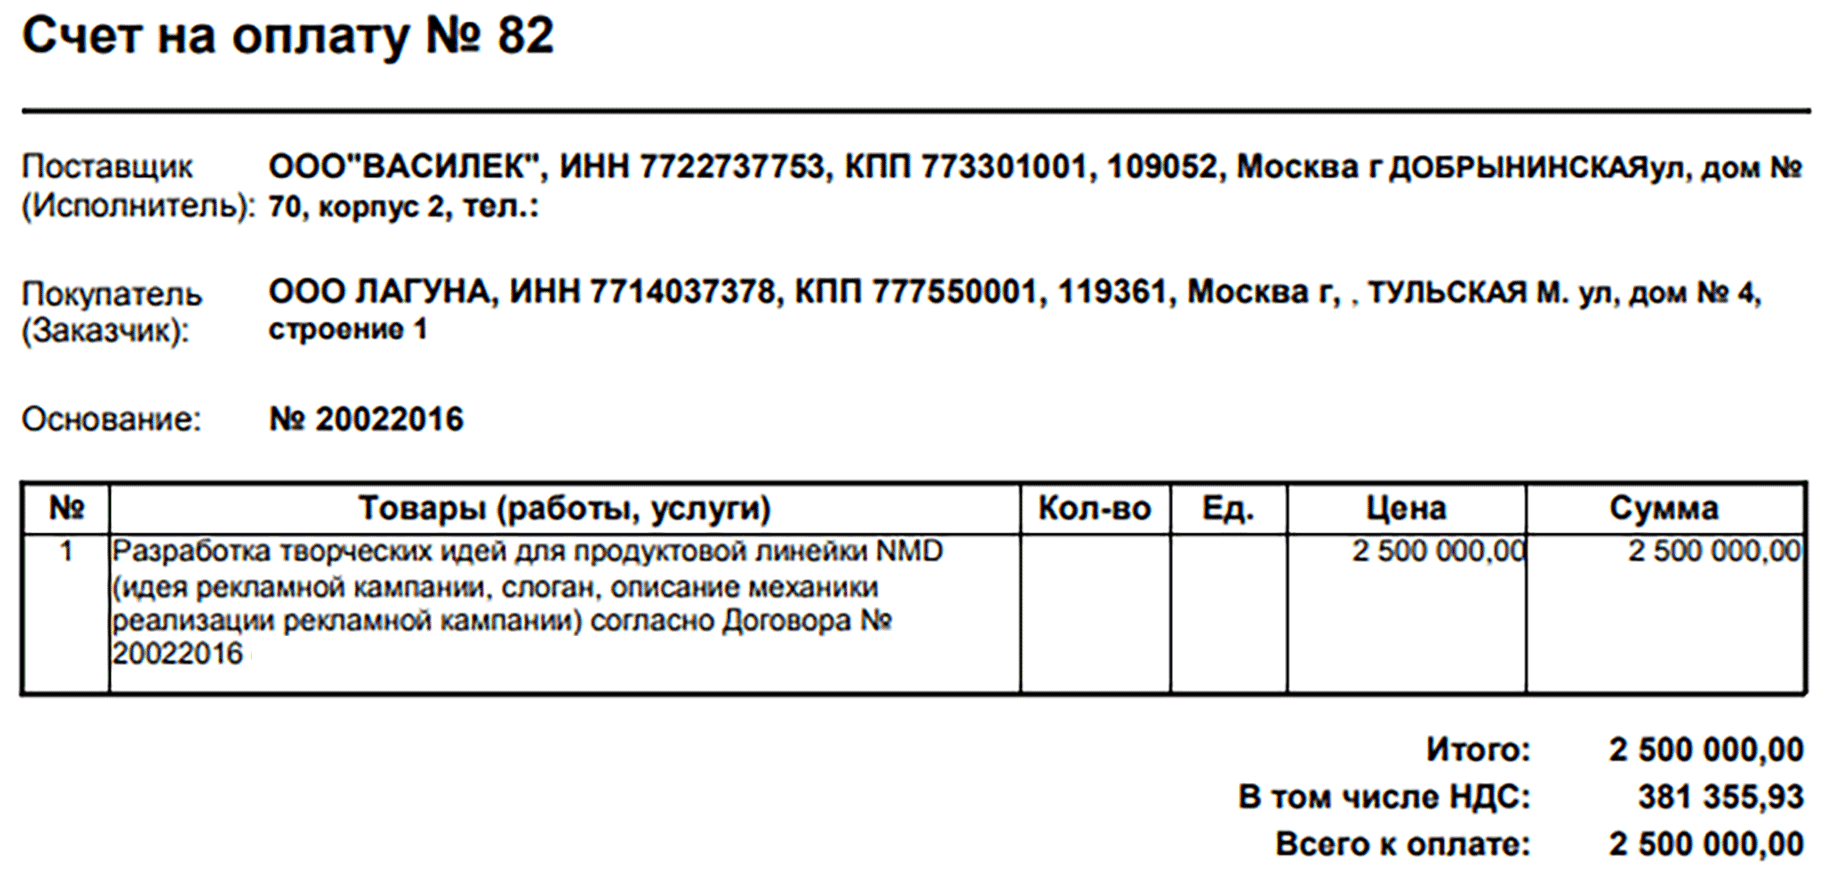

 Based on the image, here's a structured breakdown of the text and information:

1. Document Number: 82

2. Company Name: [Russian text]

3. Address: [Russian text]

4. Contact Information:
   - Phone: [Russian text]
   - Fax: [Russian text]

5. Legal Entity:
   - Type: [Russian text]
   - Number: [Russian text]

6. Document Details:
   - Number: [Russian text]
   - Date: 2022-02-16

7. Contract Information:
   - Number: [Russian text]
   - Counterparty: [Russian text]
   - Amount: 2500000 (repeated twice)

8. Financial Summary:
   - Total Amount: 2500000
   - VAT: 38135593
   - Total with VAT: 2500000

This structured format provides a comprehensive overview of the key information visible in the image, including the company details, contact information, document specifics, and financial summary.


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it, est. speed input: 655.50 toks/s, output: 78.97 toks/s]


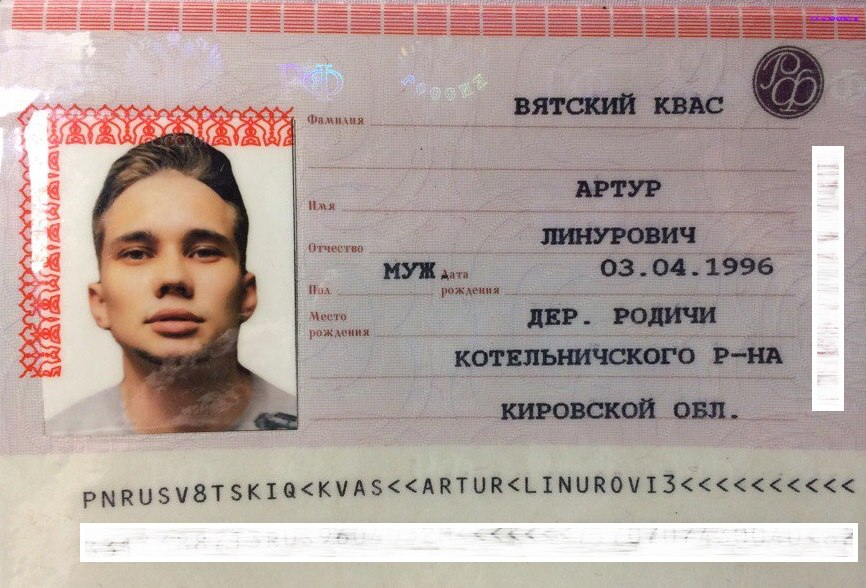

 Based on the image of the ID card, I've extracted the text and structured information. Here's a table representing the data:

| Category | Information |
|----------|-------------|
| Full Name | PNRUSV8TSKI KVAS ARTRULINUROV13 |
| Date of Birth | 03.04.1996 |
| Gender | Мужской (Male) |
| Nationality | Российский (Russian) |
| issuing authority | БАТСКИЙ КБАС (Batsky KBAS) |
| Document Type | Паспорт (Passport) |

This table provides a structured overview of the key information visible on the ID card in the image.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it, est. speed input: 270.54 toks/s, output: 84.31 toks/s]


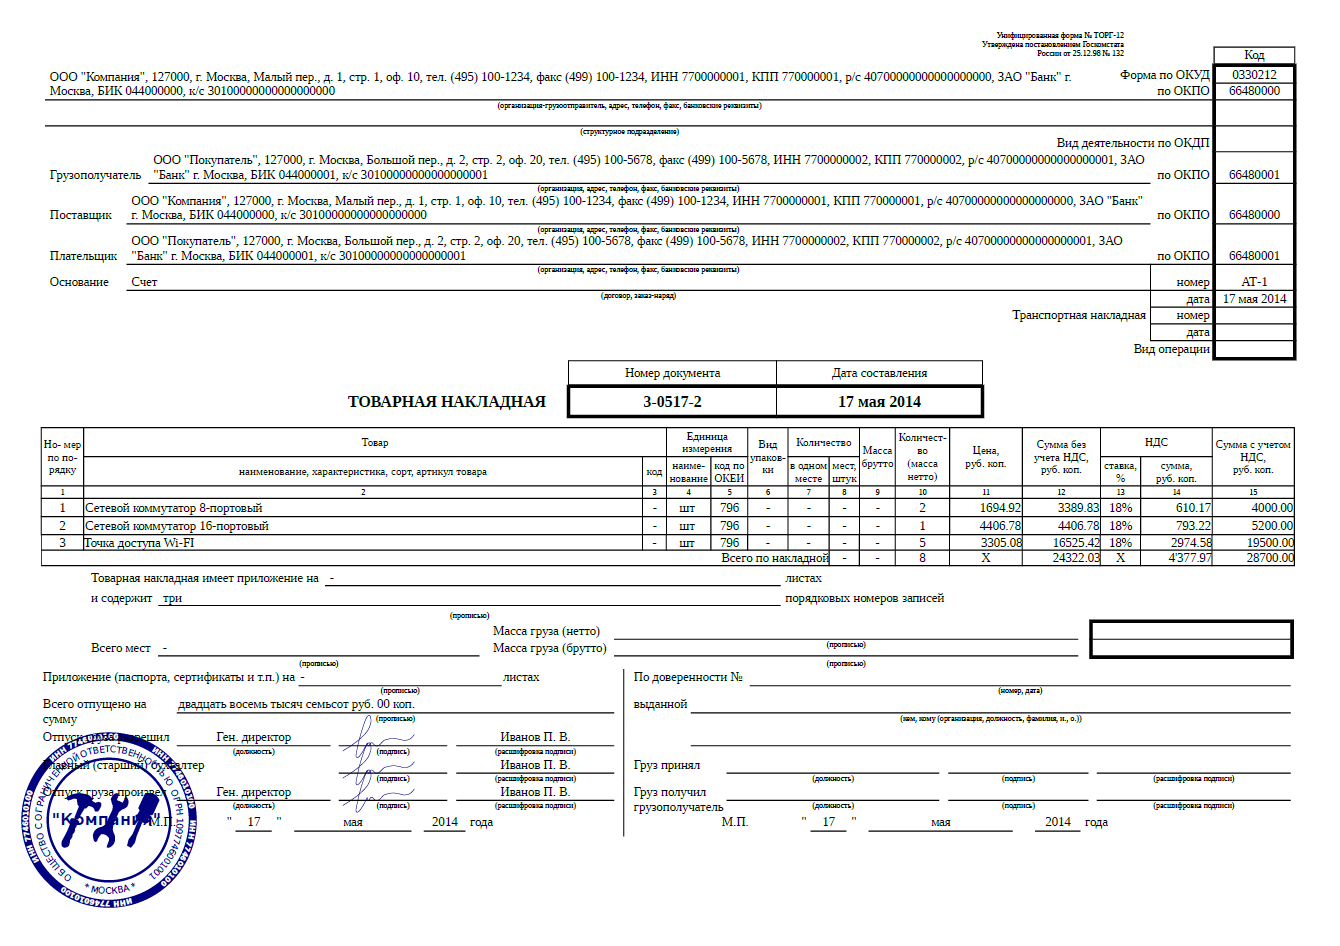

 Based on the image, I've analyzed the text and extracted the structured information. Here's a table representing the key data points:

| Category | Details |
|----------|---------|
| Document Type | Техническая документация |
| Language | Русский |
| Date | 17 марта 2014 |
| Document Number | 3-0517-2 |
| Company Name | ОАО "Коммунальные услуги" |
| Address | 127000, Москва, ул. Манежная, 1 |
| Contact | тел: (495) 100-1234, факс: (499) 100-1234 |
| Legal Entity | ООО "Банк Москвы" |
| Legal Entity Address | 127000, Москва, ул. Манежная, 1 |
| Legal Entity Contact | тел: (495) 100-5678, факс: (499) 100-5678 |
| Document Purpose | Информация о предоставлении услуг |
| Services Listed | Водоснабжение, канализация, электроснабжение |
| Services Period | Январь-февраль 2014 |
| Payment Period | Январь-февраль 2014 |
| Signature | Подпись руководителя ОАО "Коммунальные услуги" |
| Signature Date | 17 марта 2014 |
| Authorized Person | Иванов И.Б. |
| Authorized Position | Главный accountan

In [64]:
for filename in Path('./images/').iterdir():
    inputs = {
        "prompt": prompt,
        "multi_modal_data": {
            "image": PilImage.open(filename).convert('RGB')
        },
    }
    outputs = llm.generate(inputs, sampling_params=sampling_params)

    display(Image(filename))
    for o in outputs:
        generated_text = o.outputs[0].text
        print(generated_text)
    